<a href="https://colab.research.google.com/github/garima-mahato/END2/blob/main/END2_Session3_PytorchAssignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Identity Adder
---



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
%cd 'gdrive/MyDrive/END2'

/content/gdrive/MyDrive/END2


# Code
---

In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import Compose, ToTensor
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt
from random import randrange

In [ ]:
from torch_lr_finder import *

  pip install torch-lr-finder -v --global-option="amp"


In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

## Utility
---

In [ ]:
# visualize accuracy and loss graph
def visualize_graph(train_losses, train_acc, test_losses, test_acc):
  fig, axs = plt.subplots(2,2,figsize=(15,10))
  axs[0, 0].plot(train_losses)
  axs[0, 0].set_title("Training Loss")
  axs[1, 0].plot(train_acc)
  axs[1, 0].set_title("Training Accuracy")
  axs[0, 1].plot(test_losses)
  axs[0, 1].set_title("Test Loss")
  axs[1, 1].plot(test_acc)
  axs[1, 1].set_title("Test Accuracy")

In [ ]:
def visualize_save_train_vs_test_graph(EPOCHS, dict_list, title, xlabel, ylabel, PATH, name="fig"):
  plt.figure(figsize=(20,10))
  #epochs = range(1,EPOCHS+1)
  for label, item in dict_list.items():
    x = np.linspace(1, EPOCHS+1, len(item))
    plt.plot(x, item, label=label)
  
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.legend()
  plt.savefig(PATH+"/"+name+".png")

In [ ]:
def display_model_eval(model, test_loader):
  # get some random training images
  dataiter = iter(test_loader)
  images, numbers, target_nums, target_sums = dataiter.next()
  with torch.no_grad():
    images, numbers = images.to(device), numbers.to(device)
    nums, sums = model(images, numbers)
    pred_num = (F.log_softmax(nums, dim=1)).argmax(dim=1, keepdim=True) # get the index of the max log-probability
    pred_sum = (F.log_softmax(sums, dim=1)).argmax(dim=1, keepdim=True)

    figure = plt.figure(figsize=(12, 12))
    figure.suptitle('Model Prediction Results', fontsize=16)
    cols, rows = 3, 3
    for i in range(1, cols * rows + 1):
        image = images[i-1].cpu()
        number = numbers[i-1].cpu().item()
        num = pred_num[i-1].cpu().item()
        sum = pred_sum[i-1].cpu().item()
        target_num = target_nums[i-1].cpu().item()
        target_sum = target_sums[i-1].cpu().item()
        
        figure.add_subplot(rows, cols, i)
        plt.title(f'Target: {target_num} + {number} = {target_sum} \n Predicted: {num} + {number} = {sum}')
        plt.axis("off")
        plt.imshow(image.squeeze(), cmap="gray")
    plt.show()

In [ ]:
#view dataset

def view_dataset(loader, title):
  # get some random images
  dataiter = iter(loader)
  images, numbers, nums, sums = dataiter.next()

  figure = plt.figure(figsize=(10, 10))
  figure.suptitle(title, fontsize=16)
  cols, rows = 3, 3
  for i in range(1, cols * rows + 1):
      image = images[i].cpu().numpy()
      number = numbers[i].cpu().numpy()
      num= nums[i].cpu().item()
      sum = sums[i].cpu().item()
      figure.add_subplot(rows, cols, i)
      plt.title(f'{num} + {number} = {sum}')
      plt.axis("off")
      plt.imshow(image.squeeze(), cmap="gray")
  plt.show()

## Dataset Creation
---

In [ ]:
class IdentityAdderDataset(Dataset):
  def __init__(self, train=True, transform=None):
    self.transform = transform
    self.mnist_data = datasets.MNIST(root="data", train=train, download=True, transform=None)
    self.max_rand = 10
    self.max_sum = 19
  
  def __len__(self):
    return len(self.mnist_data)

  def __getitem__(self, idx):
    img_input, number = self.mnist_data[idx]
    rand = randrange(self.max_rand)
    sum = number + rand

    if self.transform:
      img_input = self.transform(img_input)
    
    return img_input, rand, number, sum

In [ ]:
train_transforms = transforms.Compose([
                    #transforms.ToPILImage(),
                    transforms.RandomAffine(degrees=20, translate=(0.1,0.1), scale=(0.9, 1.1)),
                    transforms.ColorJitter(brightness=0.2, contrast=0.2),
                    transforms.ToTensor(),
                    transforms.Normalize((0.1307,), (0.3081,))
                  ])

test_transforms = transforms.Compose([
                      transforms.ToTensor(),
                      transforms.Normalize((0.1307,), (0.3081,))
                  ])
train_dataset = IdentityAdderDataset(train=True, transform=train_transforms)
test_dataset = IdentityAdderDataset(train=True, transform=test_transforms)
eval_dataset = IdentityAdderDataset(train=False, transform=test_transforms)

In [ ]:
# set seed
random_seed = 1
torch.manual_seed(random_seed)
batch_size = 128
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}

ratio = 0.2
num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(ratio * num_train))

np.random.seed(random_seed)
np.random.shuffle(indices)

train_idx, test_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

# creating train data loader with transformations
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, **kwargs)

# creating test data loader with transformations
#test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = DataLoader(test_dataset, batch_size=batch_size, sampler=test_sampler, **kwargs)

eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=True, **kwargs)

In [ ]:
print(f'Training Dataset size: {len(train_idx)}')
print(f'Validation Dataset size: {len(test_idx)}') 
print(f'Test.Evaluation Dataset size: {len(eval_dataset)}') 

Training Dataset size: 48000
Validation Dataset size: 12000
Test.Evaluation Dataset size: 10000


### View dataset
---

1) Training dataset

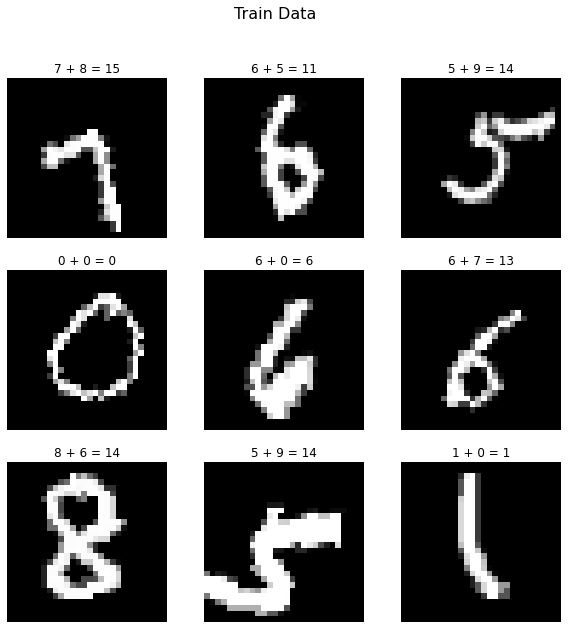

In [ ]:
view_dataset(train_loader,'Train Data')

2) Test dataset

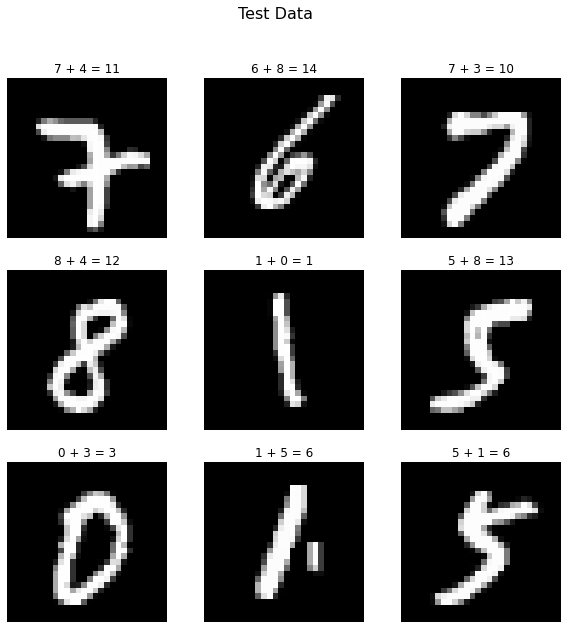

In [ ]:
view_dataset(test_loader, 'Test Data')

3) Evaluation Dataset

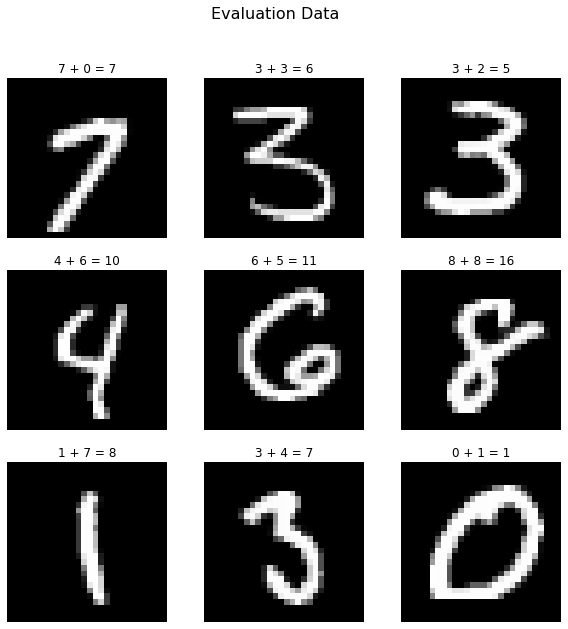

In [ ]:
view_dataset(eval_loader, 'Evaluation Data')

## Model
---


In [ ]:
class IdentityAdderModel(nn.Module):
  def __init__(self, num_channels=1, img_classes=10, sum_classes=19, dropout=0.1):
    super(IdentityAdderModel, self).__init__()
    self.num_channels = num_channels
    self.img_classes = img_classes
    self.sum_classes = sum_classes
    self.dropout = dropout

    # block 1
    self.conv1 = nn.Sequential(
        nn.Conv2d(self.num_channels, 8, 3, padding=1,bias=False),   #Input : 28*28*1 - Output : 28*28*8 -  RF : 3*3
        nn.ReLU(),            
        nn.BatchNorm2d(8),
        nn.Dropout(self.dropout)
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(8, 8, 3, padding=1,bias=False),  #Input : 28*28*8 - Output : 28*28*8 -  RF : 5*5
        nn.ReLU(),            
        nn.BatchNorm2d(8),
        nn.Dropout(self.dropout)
    )
    self.pool1 = nn.MaxPool2d(2, 2)                 #Input : 28*28*8 - Output : 14*14*8 -  RF : 6*6

    # block 2
    self.conv3 = nn.Sequential(
        nn.Conv2d(8, 16, 3, padding=1,bias=False),  #Input : 14*14*8 - Output : 14*14*16 -  RF : 10*10
        nn.ReLU(),            
        nn.BatchNorm2d(16),
        nn.Dropout(self.dropout)
    )
    self.conv4 = nn.Sequential(
        nn.Conv2d(16, 16, 3, padding=1,bias=False),  #Input : 14*14*16 - Output : 14*14*16 -  RF : 14*14
        nn.ReLU(),            
        nn.BatchNorm2d(16),
        nn.Dropout(self.dropout)
    )
    self.pool2 = nn.MaxPool2d(2, 2)                          #Input : 14*14*16 - Output : 7*7*16 -  RF : 16*16

    # block 3
    self.conv5 = nn.Sequential(
        nn.Conv2d(16, 16, 3, padding=1, bias=False),             #Input : 7*7*16 - Output : 7*7*16 -  RF : 24*24
        nn.ReLU(),            
        nn.BatchNorm2d(16)
    )
    self.conv6 = nn.Sequential(
        nn.Conv2d(16, 16, 3,bias=False),             #Input : 7*7*16 - Output : 5*5*32 -  RF : 32*32
        nn.ReLU(),            
        nn.BatchNorm2d(16),
        nn.Dropout(self.dropout)
    )
    self.gap = nn.AvgPool2d(kernel_size=5)
    self.flatten = nn.Flatten()

    self.fc1 = nn.Sequential(
        nn.Linear(16, 20, bias=False),
        nn.BatchNorm1d(20),
        nn.ReLU()
    )
    self.fc2 = nn.Sequential(
        nn.Linear(30, 64, bias=False),
        nn.BatchNorm1d(64),
        nn.ReLU()
    )
    self.out_num = nn.Sequential(
        nn.Linear(64, self.img_classes, bias=False)
    )
    self.out_sum = nn.Sequential(
        nn.Linear(64, self.sum_classes, bias=False)
    )
  
  def forward(self, img, num):
    x = self.conv1(img)
    x = self.conv2(x)
    x = self.pool1(x)

    x = self.conv3(x)
    x = self.conv4(x)
    x = self.pool2(x)

    x = self.conv5(x)
    x = self.conv6(x)
    x = self.gap(x)
    x = self.flatten(x)
    x = self.fc1(x)

    inp2 = torch.squeeze(F.one_hot(num.long(), num_classes=self.img_classes), dim=1)
    inp = torch.cat([x, inp2], 1)
    x = self.fc2(inp)

    y1 = self.out_num(x)
    y2 = self.out_sum(x)

    return y1, y2

**Model Summary**

In [ ]:
model = IdentityAdderModel().to(device)
summary(model, input_size=[[1, 28, 28],[1]], batch_size=1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [1, 8, 28, 28]              72
              ReLU-2             [1, 8, 28, 28]               0
       BatchNorm2d-3             [1, 8, 28, 28]              16
           Dropout-4             [1, 8, 28, 28]               0
            Conv2d-5             [1, 8, 28, 28]             576
              ReLU-6             [1, 8, 28, 28]               0
       BatchNorm2d-7             [1, 8, 28, 28]              16
           Dropout-8             [1, 8, 28, 28]               0
         MaxPool2d-9             [1, 8, 14, 14]               0
           Conv2d-10            [1, 16, 14, 14]           1,152
             ReLU-11            [1, 16, 14, 14]               0
      BatchNorm2d-12            [1, 16, 14, 14]              32
          Dropout-13            [1, 16, 14, 14]               0
           Conv2d-14            [1, 16,

## Training, Testing and Evaluation Code
---

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, criterion, optimizer, epoch, scheduler=None):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (inp1, inp2, num, sum) in enumerate(pbar):
    # get samples
    inp1, inp2, num, sum = inp1.to(device), inp2.to(device), num.to(device), sum.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    out1, out2 = model(inp1, inp2)

    # Calculate loss
    loss = criterion(out1, num) + criterion(out2, sum)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()
    if scheduler is not None:
		    scheduler.step()

    # Update pbar-tqdm
    
    pred1 = (F.log_softmax(out1, dim=1)).argmax(dim=1, keepdim=True) #out1.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    pred2 = (F.log_softmax(out2, dim=1)).argmax(dim=1, keepdim=True) #out2.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += torch.logical_and(pred1.eq(num.view_as(pred1)), pred2.eq(sum.view_as(pred2))).sum().item()
    processed += len(inp1)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader, criterion, scheduler=None):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for inp1, inp2, num, sum in test_loader:
            # get samples
            inp1, inp2, num, sum = inp1.to(device), inp2.to(device), num.to(device), sum.to(device)
            out1, out2 = model(inp1, inp2)
            # Calculate loss
            loss = criterion(out1, num) + criterion(out2, sum)
            test_loss += torch.sum(loss).item()  # sum up batch loss
            pred1 = (F.log_softmax(out1, dim=1)).argmax(dim=1, keepdim=True) #out1.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            pred2 = (F.log_softmax(out2, dim=1)).argmax(dim=1, keepdim=True) #out2.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += torch.logical_and(pred1.eq(num.view_as(pred1)), pred2.eq(sum.view_as(pred2))).sum().item()

    test_loss /= len(test_loader.sampler)
    if scheduler is not None:
		    scheduler.step(test_loss)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.sampler),
        100. * correct / len(test_loader.sampler)))
    
    test_acc.append(100. * correct / len(test_loader.sampler))


# Evaluate model

def evaluate(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    loss_num = 0
    loss_sum = 0
    correct_num = 0
    correct_sum = 0
    with torch.no_grad():
        for image, rand_num, num, sum in test_loader:
            # get samples
            image, rand_num, num, sum = image.to(device), rand_num.to(device), num.to(device), sum.to(device)
            out_num, out_sum = model(image, rand_num)
            # Calculate loss
            loss_num += torch.sum(criterion(out_num, num)).item()
            loss_sum += torch.sum(criterion(out_sum, sum)).item()
            loss = criterion(out_num, num) + criterion(out_sum, sum)
            test_loss += torch.sum(loss).item()  # sum up batch loss
            pred_num = (F.log_softmax(out_num, dim=1)).argmax(dim=1, keepdim=True) #out1.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            pred_sum = (F.log_softmax(out_sum, dim=1)).argmax(dim=1, keepdim=True) #out2.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct_num += pred_num.eq(num.view_as(pred_num)).sum().item()
            correct_sum += pred_sum.eq(sum.view_as(pred_sum)).sum().item()
            correct += torch.logical_and(pred_num.eq(num.view_as(pred_num)), pred_sum.eq(sum.view_as(pred_sum))).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    avg_loss_num = loss_num / len(test_loader.dataset)
    avg_loss_sum = loss_sum / len(test_loader.dataset)
    avg_loss = test_loss

    acc_num = 100. * correct_num / len(test_loader.dataset)
    acc_sum = 100. * correct_sum / len(test_loader.dataset)
    acc = 100. * correct / len(test_loader.dataset)

    print('+--------------------------+')
    print('   Model Evaluation Result')
    print('+--------------------------+')
    print(f'Average Loss for MNIST Number Prediction: {avg_loss_num}')
    print(f'Average Loss for Sum Prediction: {avg_loss_sum}')
    print(f'Average Loss for both Prediction: {avg_loss_num}')
    print(f'Accuracy for Sum Prediction: {acc_sum}')
    print(f'Accuracy for MNIST Number Prediction: {acc_num}')
    print(f'Accuracy for both Prediction: {acc}')
    print('+--------------------------+')

## Experimentation
---

#### With LR=0.01
---

**Model Building and Training**

In [ ]:
# Instantiate the model
model = IdentityAdderModel().to(device)
criterion = nn.CrossEntropyLoss()
# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

epochs = 15

for epoch in range(1, epochs+1):
    print(f'\nEPOCH {epoch}/{epochs}')
    train(model, device, train_loader, criterion, optimizer, epoch)
    test(model, device, test_loader, criterion)

  0%|          | 0/375 [00:00<?, ?it/s]


EPOCH 1/15


Loss=1.0322102308273315 Batch_id=374 Accuracy=44.63: 100%|██████████| 375/375 [00:23<00:00, 16.18it/s]
  0%|          | 0/375 [00:00<?, ?it/s]


Test set: Average loss: 0.0076, Accuracy: 10928/12000 (91.07%)


EPOCH 2/15


Loss=0.4946836233139038 Batch_id=374 Accuracy=93.14: 100%|██████████| 375/375 [00:23<00:00, 16.19it/s]
  0%|          | 0/375 [00:00<?, ?it/s]


Test set: Average loss: 0.0020, Accuracy: 11622/12000 (96.85%)


EPOCH 3/15


Loss=0.27549850940704346 Batch_id=374 Accuracy=95.51: 100%|██████████| 375/375 [00:23<00:00, 16.03it/s]
  0%|          | 0/375 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 11629/12000 (96.91%)


EPOCH 4/15


Loss=0.23915772140026093 Batch_id=374 Accuracy=96.25: 100%|██████████| 375/375 [00:22<00:00, 16.38it/s]
  0%|          | 0/375 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 11775/12000 (98.12%)


EPOCH 5/15


Loss=0.07156952470541 Batch_id=374 Accuracy=96.45: 100%|██████████| 375/375 [00:23<00:00, 16.10it/s]
  0%|          | 0/375 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 11753/12000 (97.94%)


EPOCH 6/15


Loss=0.09192883968353271 Batch_id=374 Accuracy=96.89: 100%|██████████| 375/375 [00:23<00:00, 16.19it/s]
  0%|          | 0/375 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 11756/12000 (97.97%)


EPOCH 7/15


Loss=0.31063559651374817 Batch_id=374 Accuracy=97.13: 100%|██████████| 375/375 [00:22<00:00, 16.35it/s]
  0%|          | 0/375 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 11796/12000 (98.30%)


EPOCH 8/15


Loss=0.09314237534999847 Batch_id=374 Accuracy=97.19: 100%|██████████| 375/375 [00:22<00:00, 16.44it/s]
  0%|          | 0/375 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 11794/12000 (98.28%)


EPOCH 9/15


Loss=0.16797074675559998 Batch_id=374 Accuracy=97.43: 100%|██████████| 375/375 [00:22<00:00, 16.33it/s]
  0%|          | 0/375 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 11848/12000 (98.73%)


EPOCH 10/15


Loss=0.047105997800827026 Batch_id=374 Accuracy=97.39: 100%|██████████| 375/375 [00:22<00:00, 16.36it/s]
  0%|          | 0/375 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 11836/12000 (98.63%)


EPOCH 11/15


Loss=0.12345760315656662 Batch_id=374 Accuracy=97.47: 100%|██████████| 375/375 [00:23<00:00, 16.26it/s]
  0%|          | 0/375 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 11814/12000 (98.45%)


EPOCH 12/15


Loss=0.07551822811365128 Batch_id=374 Accuracy=97.56: 100%|██████████| 375/375 [00:22<00:00, 16.40it/s]
  0%|          | 0/375 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 11827/12000 (98.56%)


EPOCH 13/15


Loss=0.10593828558921814 Batch_id=374 Accuracy=97.58: 100%|██████████| 375/375 [00:22<00:00, 16.30it/s]
  0%|          | 0/375 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 11852/12000 (98.77%)


EPOCH 14/15


Loss=0.061090365052223206 Batch_id=374 Accuracy=97.75: 100%|██████████| 375/375 [00:22<00:00, 16.44it/s]
  0%|          | 0/375 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 11859/12000 (98.83%)


EPOCH 15/15


Loss=0.35829782485961914 Batch_id=374 Accuracy=97.84: 100%|██████████| 375/375 [00:22<00:00, 16.40it/s]



Test set: Average loss: 0.0006, Accuracy: 11861/12000 (98.84%)



Save model

In [ ]:
print("\n Saving trained model...")
torch.save(model.state_dict(), "./model/final_model.pth")


 Saving trained model...


#### View Accuracy and Loss while model training and testing
---


 Visualizing:


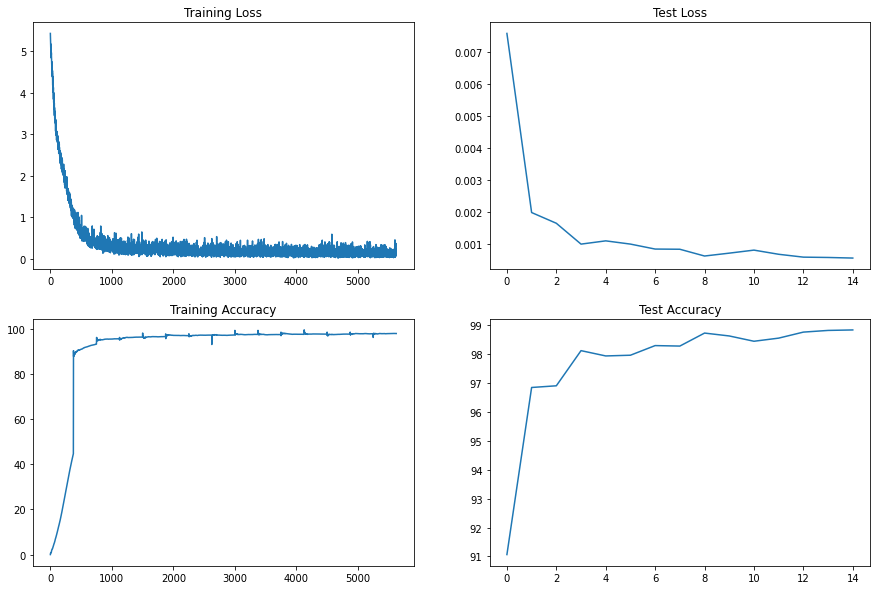

In [ ]:
print("\n Visualizing:")
visualize_graph(train_losses, train_acc, test_losses, test_acc)

#### Train versus Test Accuracy Plot
---

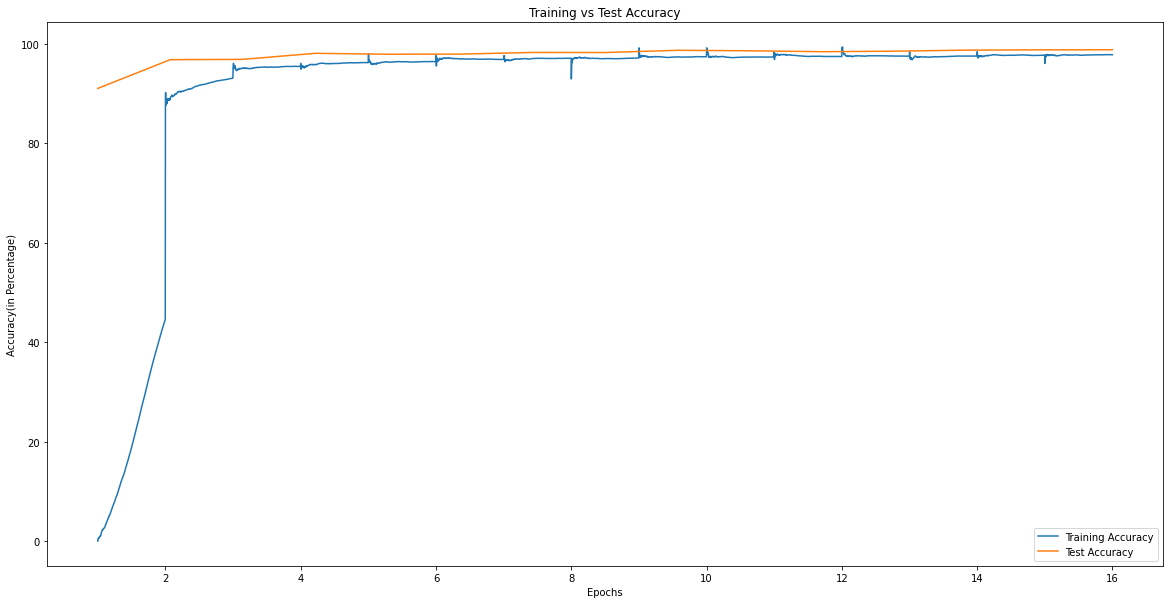

In [ ]:
dict_list = {'Training Accuracy': train_acc, 'Test Accuracy': test_acc}
title = "Training vs Test Accuracy"
xlabel = "Epochs"
ylabel = "Accuracy(in Percentage)"
name = "train_vs_test_acc_comparison_graph"

visualize_save_train_vs_test_graph(epochs, dict_list, title, xlabel, ylabel, "./visualization", name=name)

#### Evalution Metrics on Evaluation Dataset
---

In [ ]:
evaluate(model, device, eval_loader, criterion)

+--------------------------+
   Model Evaluation Result
+--------------------------+
Average Loss for MNIST Number Prediction: 0.00021177259932737797
Average Loss for Sum Prediction: 0.0002466738427290693
Average Loss for both Prediction: 0.00021177259932737797
Accuracy for Sum Prediction: 99.12
Accuracy for MNIST Number Prediction: 99.16
Accuracy for both Prediction: 99.0
+--------------------------+


#### View Model Predictions for Evaluation dataset
---

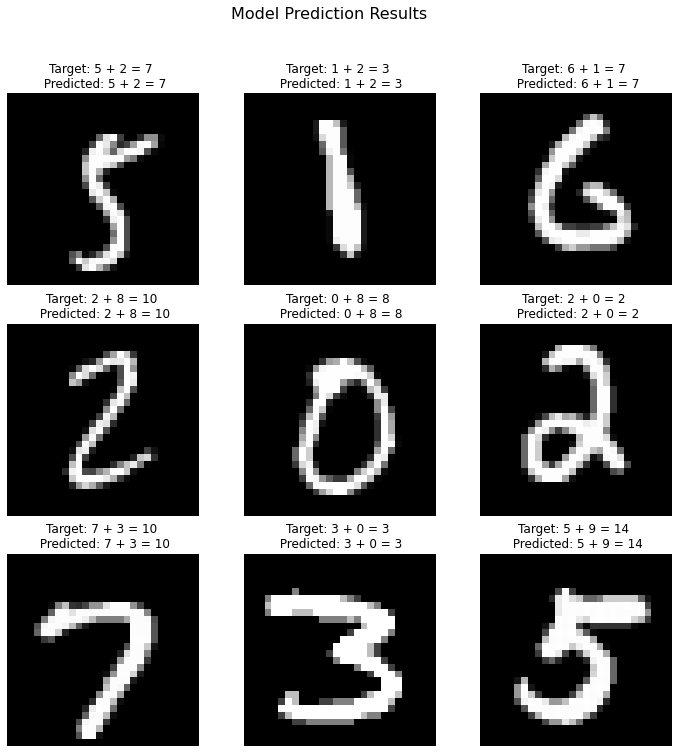

In [ ]:
display_model_eval(model, eval_loader)

### Save as ONNX model

In [ ]:
import torch.onnx
import netron

dataiter = iter(test_loader)
images, numbers, _, _ = dataiter.next()
with torch.no_grad():
    images, numbers = images.to(device), numbers.to(device)
    images, numbers = images.cpu(), numbers.cpu()
    image = images[0].cpu().unsqueeze(0)
    number = numbers[0].cpu().unsqueeze(0).unsqueeze(0)
    m = IdentityAdderModel()
    o = m(images, numbers)
    
    onnx_path = "onnx_identity_adder_model.onnx"
    torch.onnx.export(m, (image, number), onnx_path)
    
    netron.start(onnx_path)

Serving 'onnx_identity_adder_model.onnx' at http://localhost:19621


/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_opset9.py:662: UserWarning: This model contains a squeeze operation on dimension 1. If the model is intended to be used with dynamic input shapes, please use opset version 11 to export the model.
  "intended to be used with dynamic input shapes, please use opset version 11 to export the model.")
